# Exploring ggplot2: some nuanced customizations and illustrations of research visualizations

Created on February 22, 2017

Created By Peter Fontana

Contact: peter.c.fontana@gmail.com

https://www.linkedin.com/in/petercfontana

This jupyter notebook contains the notes, code, and plots for this presentation on ggplot2, providing an interactive way to interact with the code and the plots. Necessary pre-processing code is given at the top of the notebook before the presentation, allowing for the presentation code to be direct, concise and purposeful.

The presentation code begins with the section *Presentation Begins Here*.

# Setup Code

In [1]:
library(knitr) # for RMarkdown
library(ggplot2) # the GGplot
library(reshape2) # for reading data
library(scales) # for trans functions
library(grid) # for unit() in themes
library(gridExtra) # for grids of plots
library(RColorBrewer)
library(ISLR)
library(repr)
library(plyr) # for count
library(rpart)

Here we specify the size the plots should render in the jupyter notebook.

In [2]:
#library(repr)
options(repr.plot.width=6, repr.plot.height=4)

Display enough columns to show all of the R columns in the data we are working with.

In [3]:
#options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
options(repr.matrix.max.cols=30)

## Hitters Data Set Processing: Attribute

In [4]:
hitters_df <- Hitters[!is.na(Hitters$Salary), ]

In this set notice that the rows are labaled with the name of the person. We will make it a separate attribute. We will also produce additional attributes including batting average, both a continuous form and in a discrete form (to show different plots.)

In [5]:
hitters_df$rownumber = 1:nrow(hitters_df)
hitters_df$name <- row.names(hitters_df)
hitters_df$name <- sub("-","",hitters_df$name)
hitters_df$Avg <- hitters_df$Hits/hitters_df$AtBat
hitters_df$CAvg <- hitters_df$CHits/hitters_df$CAtBat

We categorize a few variables to be useful

In [6]:
# Cut by cutting the range into equal-size bins
hitters_df$RunsCat <- cut(hitters_df$Runs,5,right=FALSE,ordered_result=TRUE)
# Use a custom bin separation to cut
hitters_df$AvgCat <- cut(hitters_df$Avg,breaks=c(0,0.2,0.25,0.3,1.0),right=FALSE,ordered_result=TRUE)
# Cut by proportion
salBreaks = quantile(hitters_df$Salary,probs=c(0,0.25,0.5,0.75,1))
hitters_df$SalaryCat <- cut(hitters_df$Salary,breaks=salBreaks, right=FALSE,ordered_result=TRUE,include.lowest=TRUE)
# cut by proportion
yearBreaks = quantile(hitters_df$Years,probs=c(0,0.25,0.5,0.75,1))
hitters_df$YearsCat <- cut(hitters_df$Years,breaks=yearBreaks, right=FALSE,ordered_result=TRUE,include.lowest=TRUE)

We will also make a `high salary` for binary classification, which for this example is arbitrarily set to be 750K, which is the top 25% percentile (giving a reasonably balanced set).

In [7]:
hitters_df$high_salary <- ifelse(hitters_df$Salary >= 750, 1, 0)
hitters_df$high_salary <- as.factor(hitters_df$high_salary)

## History salary processing

In [8]:
# Get the mean, median, 25th quartile, 75th quartile, std salarys per year
hitters_year_df <- aggregate(hitters_df$Salary ~ hitters_df$Years, FUN=mean)
names(hitters_year_df) <- c("years", "mean_salary")
hitters_year_df$median_salary <- tapply(hitters_df$Salary, hitters_df$Years, FUN=median)
hitters_year_df$fq_salary <- tapply(hitters_df$Salary, hitters_df$Years, FUN=quantile,probs=c(0.25))
hitters_year_df$tq_salary <- tapply(hitters_df$Salary, hitters_df$Years, FUN=quantile,probs=c(0.75))
hitters_year_df$sd_salary <- tapply(hitters_df$Salary, hitters_df$Years, FUN=sd)
hitters_year_df$num_players <- tapply(hitters_df$Salary, hitters_df$Years, FUN=length)
head(hitters_year_df)

years,mean_salary,median_salary,fq_salary,tq_salary,sd_salary,num_players
1,149.6471,97.50,75.00,120.000,201.1676,17
2,217.0873,110.00,90.00,160.000,439.7395,21
3,172.5833,145.00,107.50,203.750,95.4859,24
4,324.2857,245.00,188.75,350.000,243.7989,28
5,569.4808,428.25,312.50,654.375,433.4801,26
6,623.8869,590.00,303.75,836.250,376.1560,28


## Logistic Regression Classifier

In [9]:
s_year.fit <- glm(high_salary~ NewLeague + Avg + Runs + Years + HmRun, data=hitters_df,family=binomial(link="logit"))
summary(s_year.fit)


Call:
glm(formula = high_salary ~ NewLeague + Avg + Runs + Years + 
    HmRun, family = binomial(link = "logit"), data = hitters_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0812  -0.6855  -0.3768   0.5561   3.2006  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.09426    1.60869  -2.545   0.0109 *  
NewLeagueN   0.48521    0.34196   1.419   0.1559    
Avg         -6.33670    6.53287  -0.970   0.3321    
Runs         0.04378    0.01023   4.282 1.85e-05 ***
Years        0.20622    0.03783   5.452 4.99e-08 ***
HmRun        0.01848    0.02254   0.820   0.4123    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 304.77  on 262  degrees of freedom
Residual deviance: 231.29  on 257  degrees of freedom
AIC: 243.29

Number of Fisher Scoring iterations: 5


In [10]:
coef(s_year.fit)

(Intercept)  NewLeagueN         Avg        Runs       Years       HmRun 
-4.09425600  0.48520705 -6.33669742  0.04378181  0.20622119  0.01848030

In [11]:
s_year_probs <- predict(s_year.fit,type="response")

In [12]:
# Make a data frame that merges the answer with the estimate probability for each person
hitters_probs <- hitters_df[,c("name","Salary","high_salary")]
hitters_probs$year_lr <- s_year_probs
head(hitters_probs)

,name,Salary,high_salary,year_lr
-Alan Ashby,Alan Ashby,475.0,0,0.23662674
-Alvin Davis,Alvin Davis,480.0,0,0.12205425
-Andre Dawson,Andre Dawson,500.0,0,0.51835385
-Andres Galarraga,Andres Galarraga,91.5,0,0.04645354
-Alfredo Griffin,Alfredo Griffin,750.0,1,0.42191607
-Al Newman,Al Newman,70.0,0,0.01938480


## Separation Plot Processing

Compute expected number of events to put on the plot

In [13]:
expected_events <- sum(hitters_probs$year_lr)
expected_events

[1] 70

In [14]:
length(hitters_probs[hitters_probs$high_salary==1, ]$year_lr)
num_events <- length(hitters_probs$year_lr)

[1] 70

In [15]:
num_events

[1] 263

Perform processing to bin results and color bin by percentage of players with high salaries

In [16]:
hitters_probs$year_lr_bin <- round(hitters_probs$year_lr,digits=1)
hitters_year_bins <- aggregate(hitters_probs$year_lr_bin ~ hitters_probs$high_salary, FUN=length)
#names(hitters_year_bins) <- c("year_lr_bin", "high_salary")
head(hitters_year_bins)

hitters_probs$high_salary,hitters_probs$year_lr_bin
0,193
1,70


In [17]:
hitters_bins <- count(hitters_probs, c('year_lr_bin',"high_salary"))
hitters_plot_frame <- as.data.frame(hitters_bins[hitters_bins$high_salary==1, c("year_lr_bin")])
names(hitters_plot_frame) <- c("year_lr_bin")
hitters_plot_frame$freq <- (hitters_bins[hitters_bins$high_salary==0, "freq" ] + hitters_bins[hitters_bins$high_salary==1, "freq" ])
#hitters_plot_frame$perc_high <- hitters_bins[hitters_bins$high_salary==1, "freq"]/(hitters_bins[hitters_bins$high_salary==0, "freq" ] + hitters_bins[hitters_bins$high_salary==1, "freq" ]) 
#hitters_plot_frame$x_max <- cumsum(hitters_plot_frame$freq)
#hitters_plot_frame$x_min <- c(0, head(hitters_plot_frame$x_max, -1))
hitters_plot_frame

year_lr_bin,freq
0.0,46
0.1,61
0.2,45
0.3,30
0.4,27
0.5,19
0.6,11
0.7,8
0.8,11
0.9,5


## Decision Tree Classifier

In [18]:
high_sal_tree <- rpart(high_salary ~ Avg + Years,data=hitters_df,maxdepth=4,method="class")
print(high_sal_tree)

n= 263 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 263 70 0 (0.73384030 0.26615970)  
   2) Years< 5.5 116  8 0 (0.93103448 0.06896552) *
   3) Years>=5.5 147 62 0 (0.57823129 0.42176871)  
     6) Avg< 0.2654681 75 24 0 (0.68000000 0.32000000) *
     7) Avg>=0.2654681 72 34 1 (0.47222222 0.52777778)  
      14) Avg>=0.2974226 22  7 0 (0.68181818 0.31818182) *
      15) Avg< 0.2974226 50 19 1 (0.38000000 0.62000000) *


## Theme

We will go through the theme later, but for now we will use a custom theme, that is altered from the theme_bw() theme in ggplot. For editing the themes, the default theme source code, available at https://github.com/tidyverse/ggplot2/blob/master/R/theme-defaults.r is quite helpful.

The `theme_gray()` is the default theme, and `theme_bw()` is their default white-background theme.

Notice that we use a custom theme that starts with the `theme_bw()` and then modifies it afterwards with the following changes.

In [19]:
# theme code
theme_bw_pf <- function(base_size = 11, base_family = "sans", title_family="serif") {
  # Starts with theme_grey and then modify some parts
  half_line <- base_size/2
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      axis.text = element_text(size=rel(0.8)),
      axis.title.x = element_text(lineheight=1.2, margin = margin(1.5*half_line,0,0,0.8*half_line/2.0)),
      axis.title.y = element_text(angle = 90, lineheight=1.2, margin = margin(0, 1.5*half_line, 0, 0.8*half_line/2.0)),
      # axis.ticks = element_line(size = rel(0.8)),
      axis.ticks = element_blank(),
      axis.line = element_blank(),
      legend.title = element_text(size = rel(1.0), hjust = 0, lineheight = 1.3,face="bold", family=title_family),
      legend.key       = element_blank(),
      legend.background = element_blank(),
      panel.background = element_rect(fill = "white", colour = NA),
      panel.border     = element_blank(),
      #panel.grid.major = element_line(colour = "grey92"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.spacing = unit(2*half_line,"pt"),
      strip.background = element_rect(fill = "grey80", colour = "grey80", size=0.2),
      plot.title = element_text(size= rel(1.2), family=title_family, face="bold", lineheight=1.2, margin= margin(0,0,half_line*2.0,0), hjust = 0)
    )
}

Now we set the default theme with our custom theme

In [20]:
#defalut_theme <- theme_set(theme_bw_pf(base_size=10,base_family="Source Sans Pro", title_family="Source Serif Pro"))
defalut_theme <- theme_set(theme_bw_pf(base_size=10,base_family="sans", title_family="Palatino"))

In [21]:
hitters_class_frame <- hitters_df[,c("name","high_salary","Salary","Years","Avg")]
hitters_class_frame$dt_class <- predict(high_sal_tree, hitters_df, type="class")

# Code for Plots in Slides

Here is the code used to produce the plots in the presentation slides.

## Quick Exploratory Plots

In [22]:
eq1_filepath <- "./hist_plot_eq.png" 
eq_plot_1 <- ggplot() + geom_histogram(data=hitters_df,aes(x=Salary, y=..count..),binwidth=250,closed="left") + theme_bw()
ggsave(eq1_filepath, eq_plot_1, dpi=300, width = 6, height = 4, units="in")

In [23]:
eq2_filepath <- "./yearline_plot_eq.png" 
eq_plot_2 <- ggplot() +  geom_line(data=hitters_year_df, aes(x=years,y=median_salary))  + theme_bw()
ggsave(eq2_filepath, eq_plot_2, dpi=300, width = 6, height = 4, units="in")

In [24]:
eq3_filepath <- "./yearbox_plot_eq.png" 
eq_plot_3 <- ggplot() +  geom_boxplot(data=hitters_df, aes(x=factor(Years),y=Salary))  + theme_grey()
ggsave(eq3_filepath, eq_plot_3, dpi=300, width = 6, height = 4, units="in")

## Presentation-Quality Plots

In [25]:
pq1_filepath <- "./hist_plot_pq.png"
pq_plot_1 <- ggplot() + 
  geom_histogram(data=hitters_df,aes(x=Salary, y=..count..,fill=..count..),binwidth=250,color="black",closed="left") + 
  geom_histogram(data=hitters_df,aes(x=Salary,y=..count..), binwidth=25, color="black", fill=rgb(255,255,255,max=255), closed="left") + 
  geom_text(data=hitters_df, aes(x=Salary, label=..count.., vjust=-1),stat="bin",binwidth=250,size=4,closed="left") +
  scale_fill_gradient(low=rgb(127,0,255,max=255),high=rgb(0,0,255,max=255),name="Number of \nPlayers") + 
  scale_x_continuous(expand= c(0,0)) + scale_y_continuous(expand=c(0,0)) +
  coord_cartesian(ylim=c(0,120)) +
  ggtitle("Histogram of Players' Salaries") + xlab("Salary ($K)") + ylab("Number of Players") 
ggsave(pq1_filepath, pq_plot_1, dpi=300, width = 6, height = 4, units="in")

In [26]:
pq2_filepath <- "./yearline_plot_pq.png"
error_limits <- aes(x=years, ymax = tq_salary, ymin=fq_salary)
dodge <- position_dodge(width=0.8)
pq_plot_2 <- ggplot(data=hitters_year_df) +
  geom_line(aes(x=years,y=median_salary),lty=2) + scale_fill_gradient(low="#FFFFFF",high="#0000FF",name="Number of \nPlayers") + 
  geom_point(aes(x=years,y=median_salary,size=num_players,fill=num_players),shape=22,stroke=0.8,) + scale_size_continuous(name="Number of \nPlayers") +
# This plots the vertical and horizontal error bars  
 geom_errorbar(error_limits, position=dodge, width=0.8) +
  guides(colour = guide_legend()) + ylab("Salary ($K)") + xlab("Years player has played") + ggtitle("Median Salaries by Year") 
ggsave(pq2_filepath, pq_plot_2, dpi=300, width = 6, height = 4, units="in")

In [27]:
hitters_df_bp_t <- hitters_df
hitters_df_bp_t$Years_fac <- factor(hitters_df_bp_t$Years, levels=seq(1,24,by=1))

In [28]:
pq3_filepath <- "./yearbox_plot_pq.png"
pq_plot_3 <- ggplot() + geom_boxplot(data=hitters_df_bp_t, aes(x=Years_fac,y=Salary)) + scale_x_discrete(drop=FALSE) + xlab("Years Experience of Player") + ylab("Salark ($K)") + ggtitle("Median Salaries by Years Experience, \nOrdered by Years Experience")
ggsave(pq3_filepath, pq_plot_3, dpi=300, width = 6, height = 4, units="in")

# Presentation Begins Here

Here is the beginning of the code and plots used during the presentation. Necessary pre-processing code is above. This organization of the code allows us to focus on the ggplot() code and visualizations during the presentation.

We read in the dataset before in this notebook. `hitters_df` contains the **Hitters** data frame with all rows whose Salary is not missing and some extra categorical attributes that are processed.

The Hitters Data set is one of the data sets available in the `ISLR` R-Package (https://cran.r-project.org/web/packages/ISLR/index.html) which is the package that accompanies the book:

James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. *An Introduction to Statistical Learning: With Applications in R.* Corrected 6th printing, 2016 edition. New York: Springer. Available at: http://www-bcf.usc.edu/~gareth/ISL/

In our processing, we made a `high_salary` attribute for binary classification. Any player whose salary is higher than 750K is considered to have a high salary. This attribute was arbitrarily set to be 750K.

We show a little of the data to become more familiar with the data.

In [29]:
head(hitters_df)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,rownumber,name,Avg,CAvg,RunsCat,AvgCat,SalaryCat,YearsCat,high_salary
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N,1,Alan Ashby,0.2571429,0.2420992,"[-0.13,26)","[0.25,0.3)","[425,750)","[10,24]",0
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A,2,Alvin Davis,0.2713987,0.2814039,"[52,78)","[0.25,0.3)","[425,750)","[1,4)",0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N,3,Andre Dawson,0.2842742,0.2798507,"[52,78)","[0.25,0.3)","[425,750)","[10,24]",0
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N,4,Andres Galarraga,0.2710280,0.2550505,"[26,52)","[0.25,0.3)","[67.5,190)","[1,4)",0
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A,5,Alfredo Griffin,0.2845118,0.2570327,"[52,78)","[0.25,0.3)","[750,2.46e+03]","[10,24]",1
-Al Newman,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.0,A,6,Al Newman,0.2000000,0.1962617,"[-0.13,26)","[0.2,0.25)","[67.5,190)","[1,4)",0


In [31]:
dim(hitters_df)

[1] 263  29

# Introduction

Each plot in ggplot is built with multiple **layers**. Each set of points, each transformation, each window change, is part of a layer, and these functions are separated into different layers.

Quote:

> “The layered grammar is based on Wilkinson’s grammar of graphics (Wiklinson, 2005), but adds anumber of enhancements that help it to be more expressive and to fit seamlessly into the R environment” (Wickham, 2009, pg. 27)

**Idea:** we build each plot in ggplot by stacking **multiple layers**. The later layers are plotted last and on top of the previous layers and can **overwrite previous layers**.

Here are some of the layers that we will be using:

* **Plotting Window.** `ggplot()` creates an empty plotting window.
* **Plotting Objects (Data Renderers).** `geom_AAA()` creates a geometric object that contains the type of plot. Within the geoms are aesthetics (`aes()`) which takes in the variable information and the attributes to plot.
* **Coloring and Gradients.** `scale_shape_AAA()`, `scale_fill_AAA()`, `scale_color_AAA()` allows for custom point shapes, color (usually outlines).
* **Scale Transforms.** `scale_x_AAA()` and `scale_y_AAA()` allow for the scaling to be changed, including scaling transformations.
* **Coordinate window.** `coord_AAA()` allows for the coordinate windows to be changed (such as limit settings and zooms).
* **Labeling.** `xlab()`, `ylab()` and `ggtitle()` provide x-axis text, y-axis test, ant title text.
* **Theme.** `theme()` allows for modifications to the style of the plot. This can be customized with them functions and the theme default can be changed.

## Layer Illustration: Histogram plot breakdow

The best way is to show you these labels through the first motivating plot.

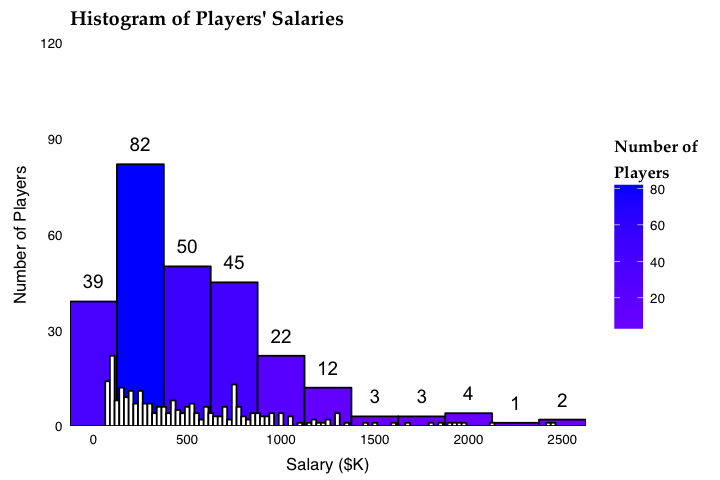

In [32]:
ggplot() + 
  geom_histogram(data=hitters_df,aes(x=Salary, y=..count..,fill=..count..),binwidth=250,color="black",closed="left") + 
  geom_histogram(data=hitters_df,aes(x=Salary,y=..count..), binwidth=25, color="black", fill=rgb(255,255,255,max=255), closed="left") + 
  geom_text(data=hitters_df, aes(x=Salary, label=..count.., vjust=-1.0),stat="bin",binwidth=250,size=4,closed="left") +
  scale_fill_gradient(low=rgb(127,0,255,max=255),high=rgb(0,0,255,max=255),name="Number of \nPlayers") + 
  coord_cartesian(ylim=c(0,120)) +
  scale_x_continuous(expand= c(0,0)) + scale_y_continuous(expand=c(0,0)) +
  ggtitle("Histogram of Players' Salaries") + xlab("Salary ($K)") + ylab("Number of Players")  

First we make a window with ggplot() (We add a panel border to show you that something shows up.)

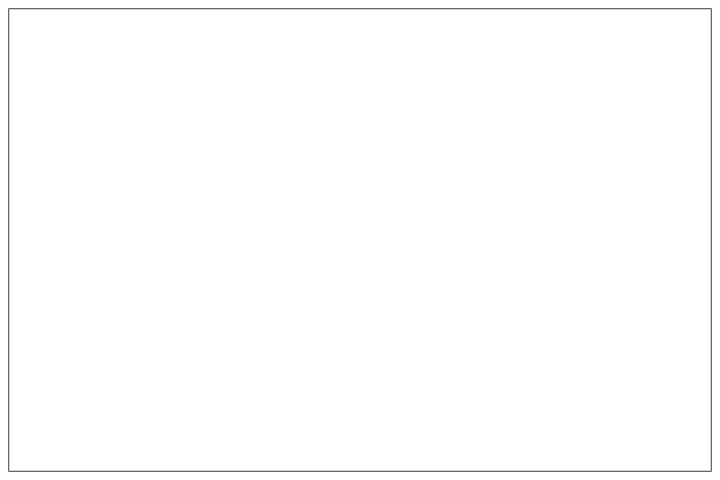

In [33]:
hist_plot_1 <- ggplot()
hist_plot_1 + theme(panel.border     = element_rect(fill = NA, colour = "grey20"))

Now we add the upper histogram without color

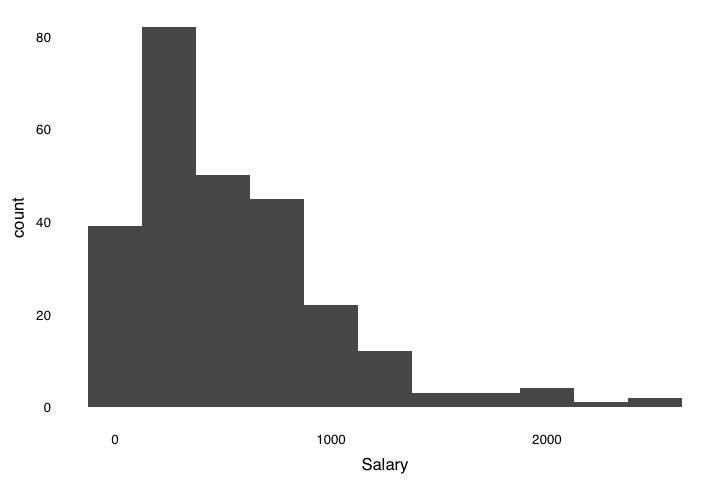

In [34]:
hist_plot_1 +  geom_histogram(data=hitters_df,aes(x=Salary, y=..count..),binwidth=250,closed="left")

Now we add the color within geom_histogram() using the default coloring

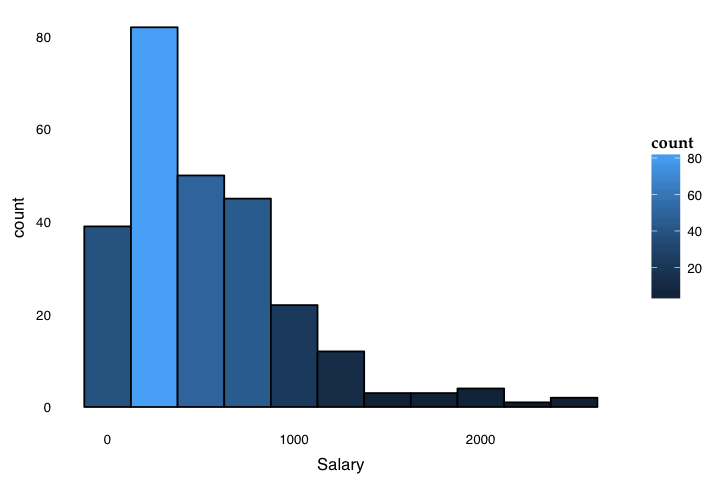

In [35]:
hist_plot_2 <- hist_plot_1 + geom_histogram(data=hitters_df,aes(x=Salary, y=..count..,fill=..count..),binwidth=250,color="black",closed="left")
hist_plot_2

Now we add the second smaller histogram with **another** `geom_histogram()`

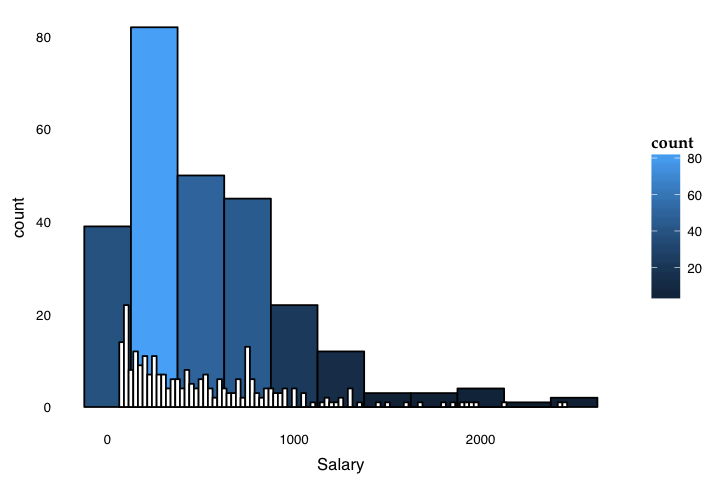

In [36]:
hist_plot_3 <- hist_plot_2 + geom_histogram(data=hitters_df,aes(x=Salary,y=..count..), binwidth=25, color="black", fill=rgb(255,255,255,max=255), closed="left")
hist_plot_3

Now we add the `geom_text()` to display the text

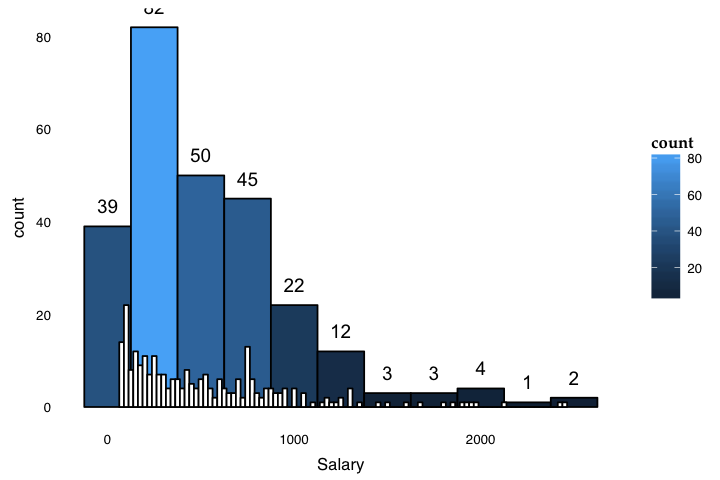

In [37]:
hist_plot_4 <- hist_plot_3 + geom_text(data=hitters_df, aes(x=Salary, label=..count.., vjust=-1),stat="bin",binwidth=250,size=4,closed="left")
hist_plot_4

Now we customize the colors with scale_fill_gradient()

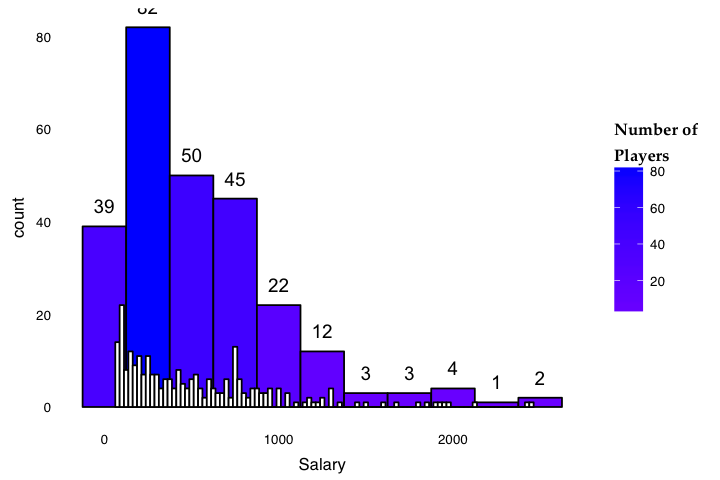

In [38]:
hist_plot_5 <- hist_plot_4 +  scale_fill_gradient(low=rgb(127,0,255,max=255),high=rgb(0,0,255,max=255),name="Number of \nPlayers")
hist_plot_5

We use `expand=c(0,0)` within `scale_x_continuous()` and `scale_y_continuous()` to force the origin at (0,0) to line the text with the plot and eliminate space from the text to the numbers. Sometimes the space is needed to diaplay all of the values, so we do not do this for every plot.

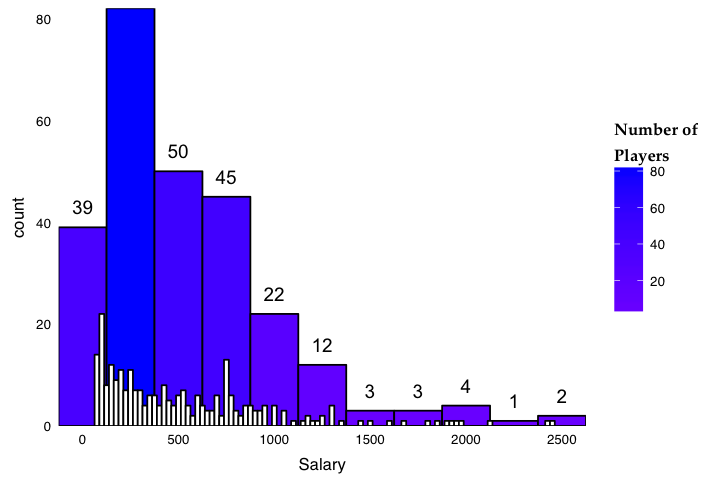

In [39]:
hist_plot_6 <- hist_plot_5 + scale_x_continuous(expand= c(0,0)) + scale_y_continuous(expand=c(0,0))
hist_plot_6

Now we change the graph limits with `coord_cartesian()`.

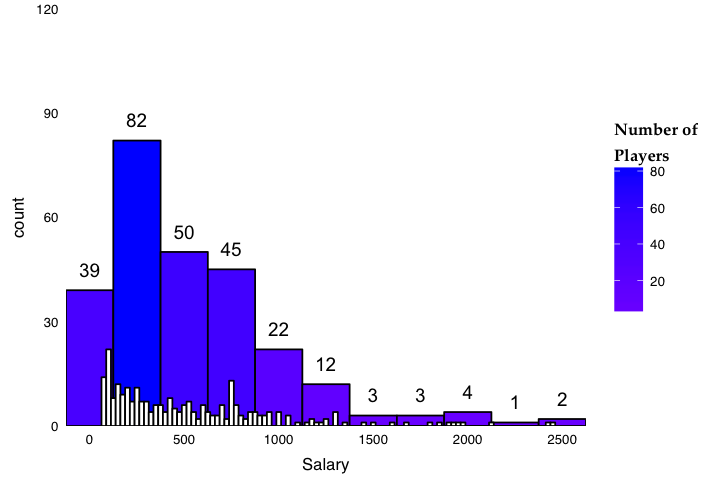

In [40]:
hist_plot_7 <- hist_plot_6 +  coord_cartesian(ylim=c(0,120))
hist_plot_7

We end with revised axes labels and a title.

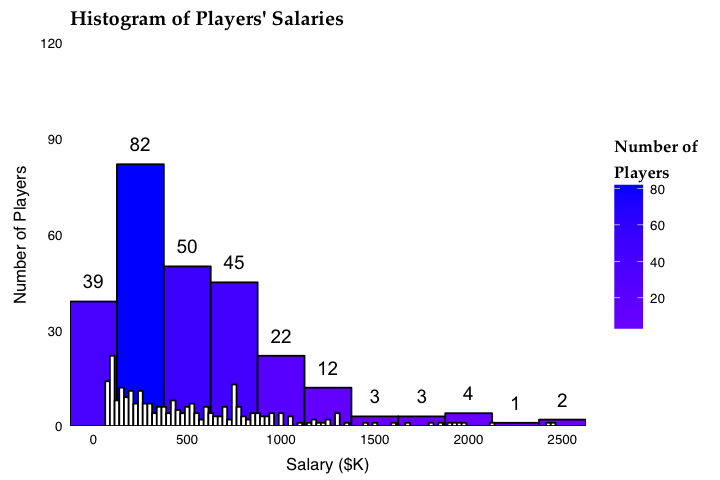

In [41]:
hist_plot_f <- hist_plot_7 + ggtitle("Histogram of Players' Salaries") + xlab("Salary ($K)") + ylab("Number of Players") 
hist_plot_f

## Layer Order Illustration: Median Salary Per Year Plot

We plot the second motivating plot, and reorder the elements to show the importance.

Remember, the elements are plotted in order, so the **last elements appear on top**.

Here is the motivating plot. We processed the data so that the aggregated salaries for all players with the same number of years experience has been processed and summarized in `hitters_year_df`

Notice that the error bars are one top, which show all of the error bars but look a bit clunky given the sizes of the points:

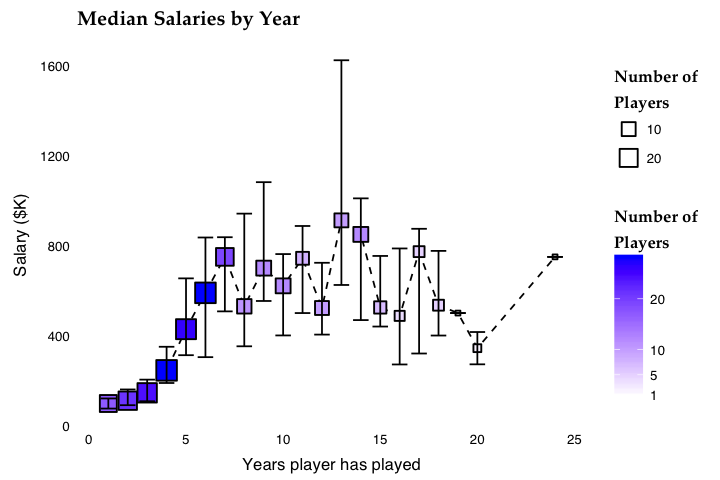

In [44]:
# Add errorbars for the standard deviation
error_limits <- aes(x=years, ymax = tq_salary, ymin=fq_salary)
dodge <- position_dodge(width=0.8)
ggplot(data=hitters_year_df) +
  geom_line(aes(x=years,y=median_salary),lty=2) + scale_fill_gradient(low="#FFFFFF",high="#0000FF",name="Number of \nPlayers",breaks=c(1,5,10,20)) + 
  geom_point(aes(x=years,y=median_salary,size=num_players,fill=num_players),shape=22,stroke=0.8) + scale_size_continuous(name="Number of \nPlayers") +
# This plots the vertical and horizontal error bars  
 geom_errorbar(error_limits, width=0.8) +
  guides(colour = guide_legend()) + ylab("Salary ($K)") + xlab("Years player has played") + ggtitle("Median Salaries by Year") 

We  now plot the error bars before the points. This makes it look clean but hides some of the error bars.

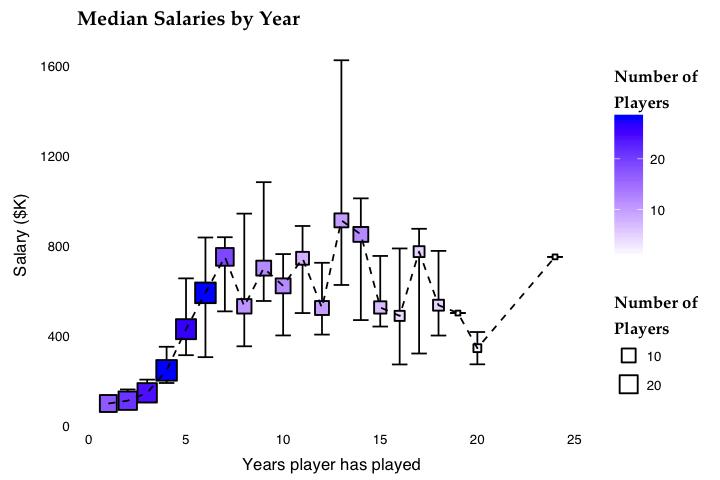

In [47]:
# Add errorbars for the standard deviation
error_limits <- aes(x=years, ymax = tq_salary, ymin=fq_salary)
dodge <- position_dodge(width=0.8)
ggplot(data=hitters_year_df) +
  geom_errorbar(error_limits, position=dodge, width=0.8) +
 geom_point(aes(x=years,y=median_salary,size=num_players,fill=num_players),shape=22,stroke=0.8) +
geom_line(aes(x=years,y=median_salary),lty=2) + scale_fill_gradient(low="#FFFFFF",high="#0000FF",name="Number of \nPlayers") +
  scale_size_continuous(name="Number of \nPlayers") +
  guides(colour = guide_legend()) + ylab("Salary ($K)") + xlab("Years player has played") + ggtitle("Median Salaries by Year")

It's a bit cluttered, but if we like, we can use a **different data set** and plot al of the points on this plot. Some might find it to be cluttered, but it can be informative to have all of the information.

As long as the axes match for the different data frames (and the values are consistent), one can plot different

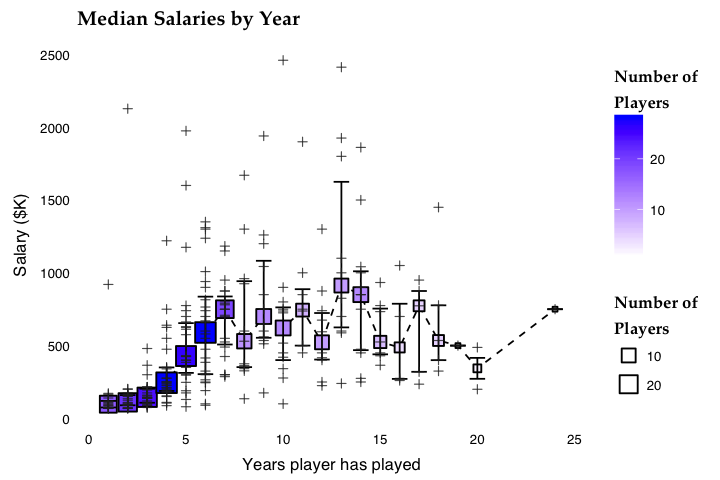

In [50]:
error_limits <- aes(x=years, ymax = tq_salary, ymin=fq_salary)
dodge <- position_dodge(width=0.8)
ggplot(data=hitters_year_df) +
  geom_line(aes(x=years,y=median_salary),lty=2) + scale_fill_gradient(low="#FFFFFF",high="#0000FF",name="Number of \nPlayers") + 
  geom_point(aes(x=years,y=median_salary,size=num_players,fill=num_players),shape=22,stroke=0.8) + 
  # This plots the vertical and horizontal error bars  
  geom_errorbar(error_limits, position=dodge, width=0.8) +
  # Extra points
  geom_point(data=hitters_df,aes(x=Years,y=Salary),alpha=0.8, shape = 3,color=rgb(40,40,40,max=255)) + scale_size_continuous(name="Number of \nPlayers") +
  guides(colour = guide_legend()) + ylab("Salary ($K)") + xlab("Years player has played") + ggtitle("Median Salaries by Year") 

Note that the axes need not be the same variable, only the values need to be consistent for the multilayers.

# Advanced Customizations

Using the same data, we will produce additional plots that customize a few aspects:

1. Custom Themes.
2. Custom Legends.
3. Reordering Items.
4. Multilayer plots.
5. Transformational Scaling.

Through the motivational plots, we discussed the concept of multilayering plots. 

We now discuss the rest of these concepts.

## Themes

In these plots, we used a custom theme, one, that is altered from the theme_bw() theme in ggplot. For editing the themes, the default theme source code, available at https://github.com/tidyverse/ggplot2/blob/master/R/theme-defaults.r is quite helpful.

The `theme_gray()` is the default theme, and `theme_bw()` is their default white-background theme.

Notice that we use a custom theme that starts with the `theme_bw()` and then modifies it afterwards with the following changes. Here is that code below

In [51]:
# theme code
theme_bw_pf <- function(base_size = 11, base_family = "sans", title_family="serif") {
  # Starts with theme_grey and then modify some parts
  half_line <- base_size/2
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      axis.text = element_text(size=rel(0.8)),
      axis.title.x = element_text(lineheight=1.2, margin = margin(1.5*half_line,0,0,0.8*half_line/2.0)),
      axis.title.y = element_text(angle = 90, lineheight=1.2, margin = margin(0, 1.5*half_line, 0, 0.8*half_line/2.0)),
      axis.ticks = element_blank(),
      axis.line = element_blank(),
      legend.title = element_text(size = rel(1.0), hjust = 0, lineheight = 1.3,face="bold", family=title_family),
      legend.key       = element_blank(),
      legend.background = element_blank(),
      panel.background = element_rect(fill = "white", colour = NA),
      panel.border     = element_blank(),
      #panel.grid.major = element_line(colour = "grey92"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.spacing = unit(2*half_line,"pt"),
      strip.background = element_rect(fill = "grey80", colour = "grey80", size=0.2),
      plot.title = element_text(size= rel(1.2), family=title_family, face="bold", lineheight=1.2, margin= margin(0,0,half_line*2.0,0), hjust = 0)
    )
}

Now we set the default theme with our custom theme

In [52]:
#defalut_theme <- theme_set(theme_bw_pf(base_size=10,base_family="Source Sans Pro", title_family="Source Serif Pro"))
defalut_theme <- theme_set(theme_bw_pf(base_size=10,base_family="sans", title_family="Palatino"))

We can also use the `theme()` within a plot to just change the theme for a single plot.

For instance, here is the histogram plot with rotated x-axis text. since the text is rotated, so are the `hjust` and `vjust`

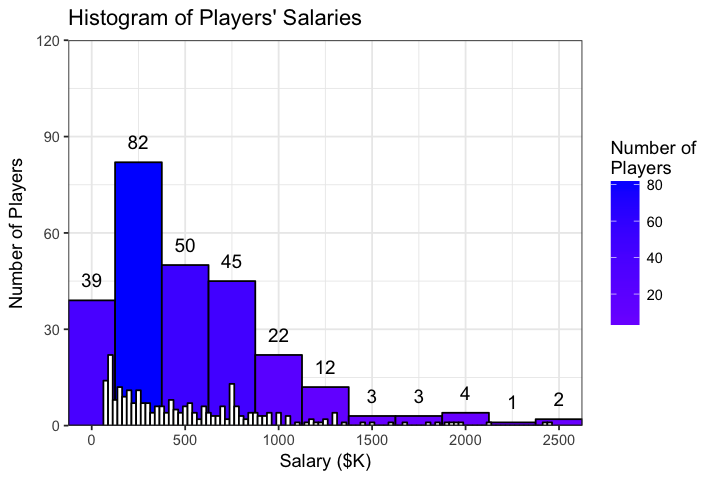

In [59]:
hist_plot_f + theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=1)) + theme_bw()

The parameters `hjust` and `vjust` control the horizontal alighment and the vertical alignment of text.

* hjust = 0 is right alignment
* hjust = 0.5 is cenetered
* hjust = 1 is left alignment

* vjust = 0 is top aligned
* vjust = 0.5 is center
* vjust = 1 is bottom.

Note that the values for `hjust` and `vjust` can be negative, greater than 1, or in-between these values for different effects. Try them out! 

For instance, notice that for this histogram, in geom_text, `vjust=-1` so that the text would show above the label.

Here is the plot with vjust = 0 and hjust = 1 to illustrate the influence of the different values.

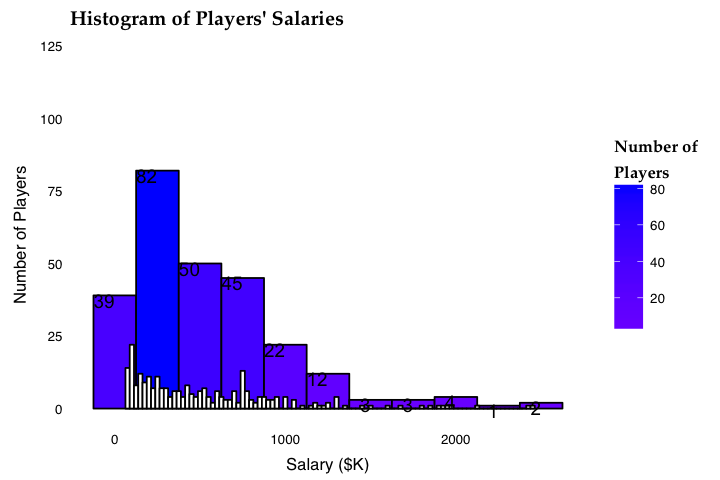

In [57]:
ggplot() + 
  geom_histogram(data=hitters_df,aes(x=Salary, y=..count..,fill=..count..),binwidth=250,color="black",closed="left") + 
  geom_histogram(data=hitters_df,aes(x=Salary,y=..count..), binwidth=25, color="black", fill=rgb(255,255,255,max=255), closed="left") + 
  geom_text(data=hitters_df, aes(x=Salary, label=..count.., vjust=0.87,hjust=1),stat="bin",binwidth=250,size=4,closed="left") +
  scale_fill_gradient(low=rgb(127,0,255,max=255),high=rgb(0,0,255,max=255),name="Number of \nPlayers") + 
  coord_cartesian(ylim=c(0,120)) +
  ggtitle("Histogram of Players' Salaries") + xlab("Salary ($K)") + ylab("Number of Players") 

## Reordering Items

We discussed how to reorder layers in a plot. Here we talk about how to reorder the factors or columns of a boxplot or barplot. Here we will improve the boxplot from before.

Here is the boxplot from before

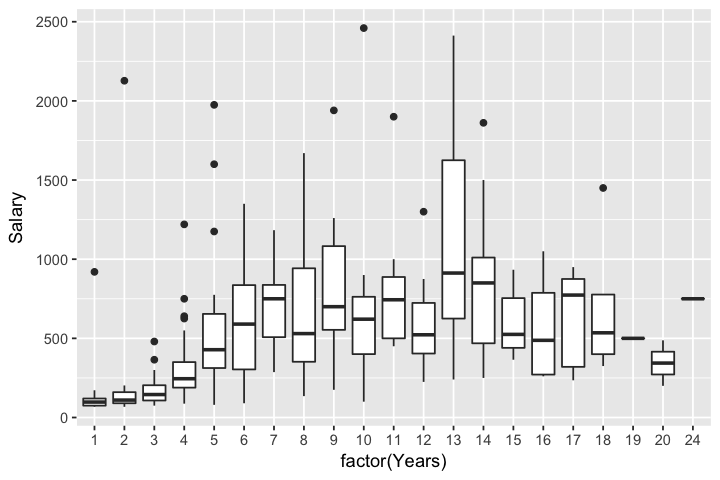

In [60]:
ggplot() +  geom_boxplot(data=hitters_df, aes(x=factor(Years),y=Salary)) + theme_grey()

Now we reorder by order of median salary from highest to lowest.

To properly reorder, we need to change the order of levels **within the factor**. Here, the factor was created in the boxplot, but this usually means reordering the factor in the plotted dataframe.

In [61]:
hitters_df_bp <- hitters_df
hitters_df_bp$Years_fac <- as.factor(hitters_df_bp$Years)

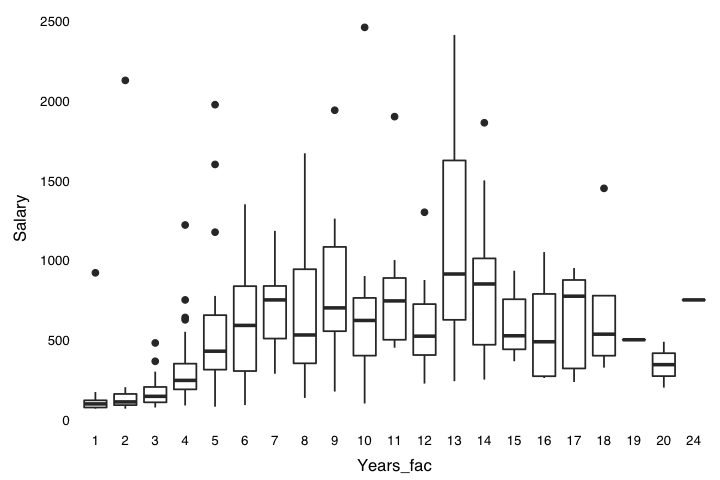

In [62]:
ggplot() + geom_boxplot(data=hitters_df_bp, aes(x=Years_fac,y=Salary))

Now we reorder them by median salary. To do this, we will use the `levels` parameter of the factor function with an `order()` command. The minus sign `-` within the `order` indicates a descending rather than ascending order.

Note that the data with the median salary has been pre-processed

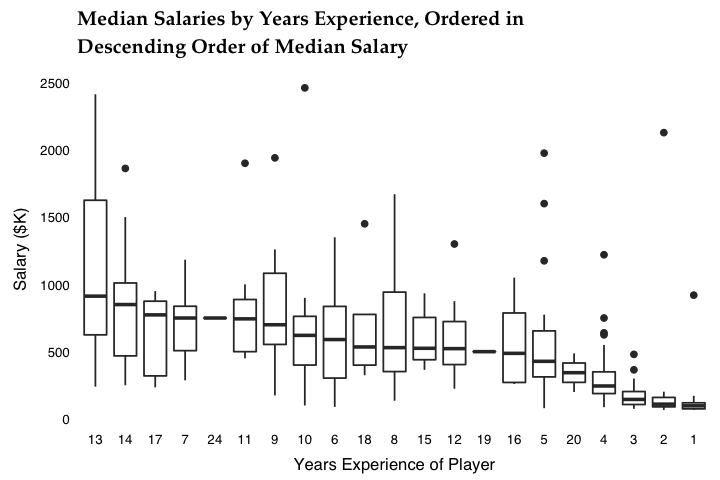

In [63]:
hitters_df_bp$Years_fac <- factor(hitters_df_bp$Years, levels = hitters_year_df$years[order(-hitters_year_df$median_salary)])
ggplot() + geom_boxplot(data=hitters_df_bp, aes(x=Years_fac,y=Salary)) + ggtitle("Median Salaries by Years Experience, Ordered in \nDescending Order of Median Salary") + xlab("Years Experience of Player") + ylab("Salary ($K)")

We can even add in orders that do not exist, such as the years 21, 22, amd 23 if we want to make the year factor closer to scale.

Note the use of `drop = FALSE` in the x axis scaling to keep the empty levels

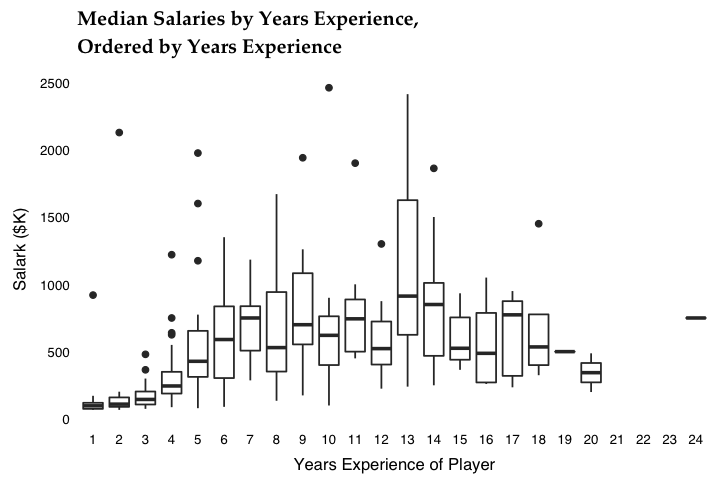

In [64]:
hitters_df_bp$Years_fac <- factor(hitters_df_bp$Years, levels=seq(1,24,by=1))
ggplot() + geom_boxplot(data=hitters_df_bp, aes(x=Years_fac,y=Salary)) + scale_x_discrete(drop=FALSE) +
xlab("Years Experience of Player") + ylab("Salark ($K)") + ggtitle("Median Salaries by Years Experience, \nOrdered by Years Experience")

## Custom Legends

Legends can be customized. Plots can also be done manually. 

Using manual legends will be covered later in this presentation.

One way to customize the legend is by changing fields in the `scale_AAA()` that was used to change the plot. We do this in the histogram with the `scale_fill`. We also did a logarithmic translation on the shading for illustration.

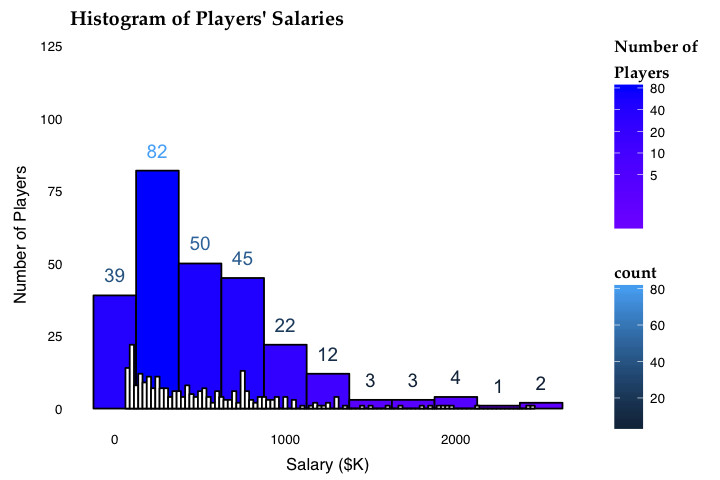

In [85]:
player_labels = c(0,5,10,20,40,80)

ggplot() + 
  geom_histogram(data=hitters_df,aes(x=Salary, y=..count..,fill=..count..),binwidth=250,color="black",closed="left") + 
  geom_histogram(data=hitters_df,aes(x=Salary,y=..count..), binwidth=25, color="black", fill=rgb(255,255,255,max=255), closed="left") + 
  geom_text(data=hitters_df, aes(x=Salary, label=..count.., vjust=-1.0,color=..count..),stat="bin",binwidth=250,size=4,closed="left") +
  coord_cartesian(ylim=c(0,120)) +
  ggtitle("Histogram of Players' Salaries") + xlab("Salary ($K)") + ylab("Number of Players") + scale_fill_gradient(low=rgb(127,0,255,max=255),high=rgb(0,0,255,max=255),name="Number of \nPlayers",trans="log10",breaks=player_labels,labels=player_labels)

## Transformational Scaling

We can use the `trans` option in `scale_x_continuous()` and `scale_y_continuous()` to apply a transformation on the scale.

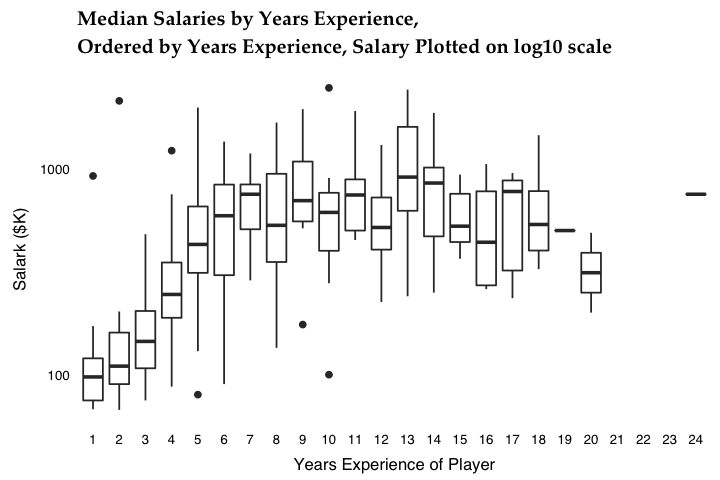

In [68]:
hitters_df_bp$Years_fac <- factor(hitters_df_bp$Years, levels=seq(1,24,by=1))
ggplot() + geom_boxplot(data=hitters_df_bp, aes(x=Years_fac,y=Salary)) + scale_x_discrete(drop=FALSE) +
scale_y_continuous(trans="log10") + xlab("Years Experience of Player") + ylab("Salark ($K)") + ggtitle("Median Salaries by Years Experience, \nOrdered by Years Experience, Salary Plotted on log10 scale")

## Window Limits

Now we change the graph limits with `coord_cartesian()`. We use `coord_cartesian()` because it keeps the data outside, rather than throwing out the data outside of the limits, which `scale_AAA_continuous()` does. 

The outside data can be used when means or other statistical aggregates are plotted. The boxplot above illustrates the difference. First, we show the boxplot again (in the original scale)

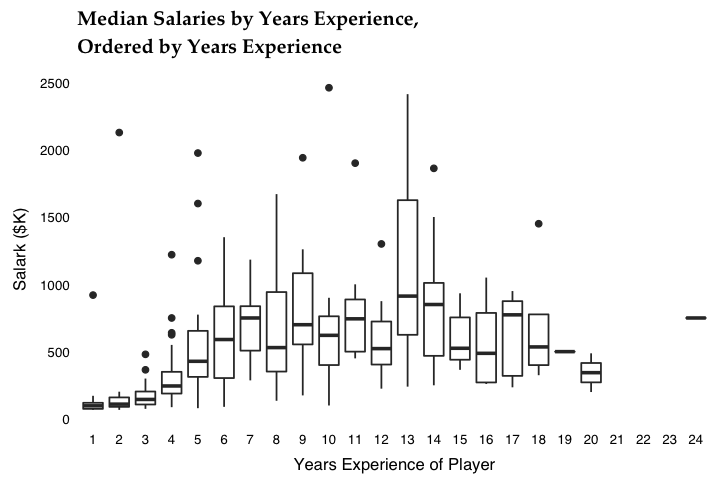

In [69]:
boxplot <- ggplot() + geom_boxplot(data=hitters_df_bp, aes(x=Years_fac,y=Salary)) + scale_x_discrete(drop=FALSE) +
xlab("Years Experience of Player") + ylab("Salark ($K)") + ggtitle("Median Salaries by Years Experience, \nOrdered by Years Experience")
boxplot

We use `coord_cartesian()` to restric the y-axis from [0,1500]. The tops are cut off and one box is incomplete, showing that we zoomed-in.

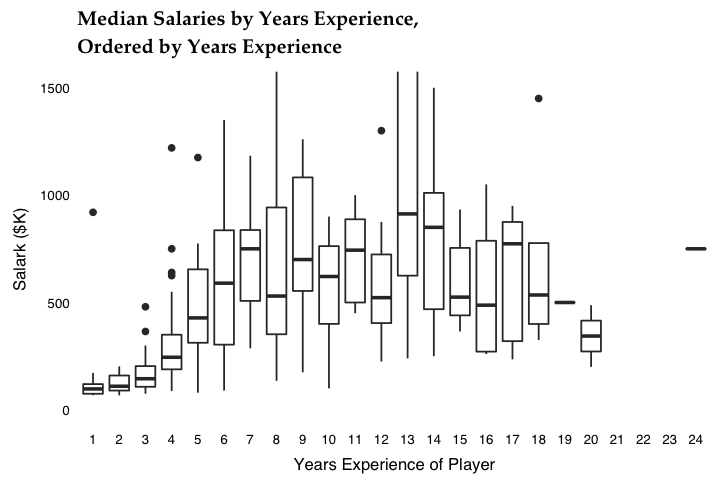

In [70]:
boxplot + coord_cartesian(ylim=c(0,1500))

When we use `scale_y_continuous()` instead, we notice that the medians are lower than before, showing that the points of salary higher than $1.5M have been removed. There is also a warning to indicate that something has happened.

Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”

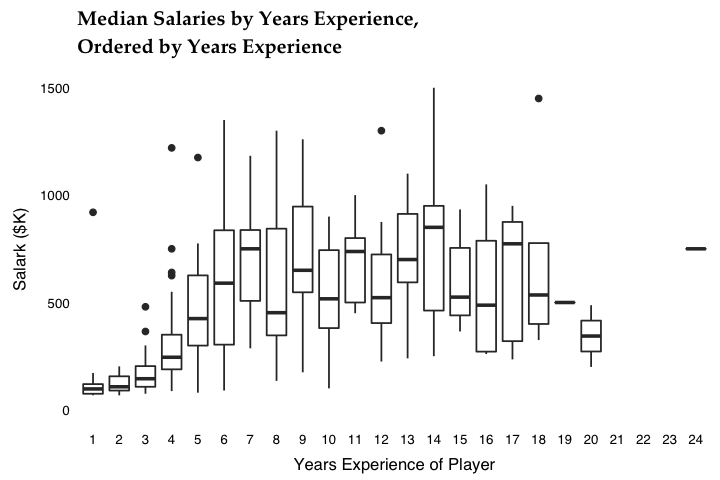

In [71]:
boxplot + scale_y_continuous(limits=c(0,1500))

# Plots from Research Papers

We will produce plots in line with visualizations from two research papers.

## Separation Plots

The first is a **separation plot**. It is from the research paper:

Greenhill, B., Ward, M. D. and Sacks, A. (2011), The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models. American Journal of Political Science, 55: 991–1002. doi:10.1111/j.1540-5907.2011.00525.x

To illustrate a separation plot, we built a simple logistic regression model on the dataset to predict the probability of  if the salary is high. For this example we are visualizing the **training set error**. Typically one will evaluate either through cross-validation or on a different data set (such as a development data set or a test data set).

The separation plot, as provided, assumes that each example has a unique probability assigned to it. For our classifier it does.

Here is the code. Notice the use of `geom_step()` instead of `geom_line()` so that there is no interpolation.

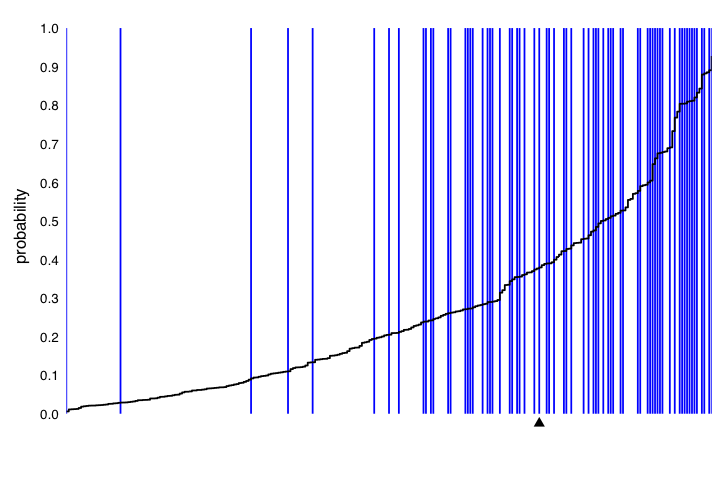

In [72]:
year_sal_probs <- hitters_probs[order(hitters_probs$year_lr), ]
sep_cols=c(rgb(255,255,255,max=255),rgb(0,0,255,max=255))

## Put expected number of events into a data frame for this plot
expected_events_df <- data.frame(matrix(0,2,nrow=1))
names(expected_events_df) <- c("X", "Y")
# Want expected events from the right, not the left, so subtract out the length
expected_events_df$X <- num_events - expected_events
# slight adjustment to replicate vjust = 0
expected_events_df$Y <- -0.025

ggplot(data=year_sal_probs) + geom_linerange(aes(color = factor(high_salary), ymin = 0, ymax = 1, x =  seq(length.out = length(year_sal_probs$high_salary))),alpha=1.0) + 
  # probability threshold line
  geom_step(aes(x = seq(length.out = length(year_sal_probs$high_salary)),y=year_lr)) +
  # expected number of events
  geom_point(data=expected_events_df,aes(x=X,y=Y),shape=17,size=2) +
  scale_color_manual(values=sep_cols, name="High Salary") + xlab("") +ylab("probability") + guides(color=FALSE) +  
  scale_y_continuous(breaks=seq(0,1,by=0.1)) + scale_x_continuous(expand=c(0,0)) +
  theme(axis.ticks.x=element_blank(),axis.text.x=element_blank())

Often, your instances will have multiple examples with the same probability. One way to handle that is to bin the examples and shade by the percentage of condition positives (in this case, players whose salaries are high).

We handle that case here.

In [75]:
head(hitters_plot_frame)

year_lr_bin,freq,perc_high,x_max,x_min,x_max_perc,x_min_perc
0.0,46,0.04347826,46,0,0.1749049,0.0000000
0.1,61,0.04918033,107,46,0.4068441,0.1749049
0.2,45,0.15555556,152,107,0.5779468,0.4068441
0.3,30,0.43333333,182,152,0.6920152,0.5779468
0.4,27,0.40740741,209,182,0.7946768,0.6920152
0.5,19,0.57894737,228,209,0.8669202,0.7946768


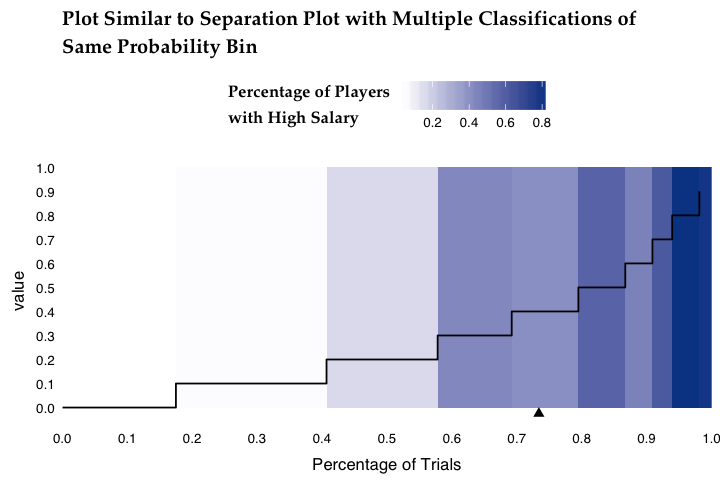

In [73]:
# Add the percentage dirty, and left and right endpoints (x_min and x_max) to the frequency table
hitters_plot_frame$perc_high <- hitters_bins[hitters_bins$high_salary==1, "freq"]/(hitters_bins[hitters_bins$high_salary==0, "freq" ] + hitters_bins[hitters_bins$high_salary==1, "freq" ]) 
hitters_plot_frame$x_max <- cumsum(hitters_plot_frame$freq)
hitters_plot_frame$x_min <- c(0, head(hitters_plot_frame$x_max, -1))
# convert to percentage so that the x-axis label has more meaning
total_width <- max(hitters_plot_frame$x_max)
hitters_plot_frame$x_max_perc <- hitters_plot_frame$x_max/total_width
hitters_plot_frame$x_min_perc <- hitters_plot_frame$x_min/total_width

## Repeat Expected events computation, but convert to percentage
expected_events_df_p <- data.frame(matrix(0,2,nrow=1))
names(expected_events_df_p) <- c("X", "Y")
# Want expected events from the right, not the left, so subtract out the length
expected_events_df_p$X <- (num_events - expected_events)/num_events
# slight adjustment to replicate vjust = 0
expected_events_df_p$Y <- -0.025

ggplot(data=hitters_plot_frame) + 
  geom_rect(aes(xmin=x_min_perc,xmax=x_max_perc,ymin=0,ymax=1,fill=perc_high)) + 
  scale_fill_gradient(low=rgb(255,255,255,max=255),high=brewer.pal(8,"Blues")[8], name="Percentage of Players \nwith High Salary") +
  # probability threshold line
  geom_step(aes(x = x_min_perc,y=year_lr_bin)) +
  # expected number of events
  geom_point(data=expected_events_df_p,aes(x=X,y=Y),shape=17,size=2) +
  scale_x_continuous(breaks=seq(0,1,by=0.1),expand=c(0,0)) + scale_y_continuous(breaks=seq(0,1,by=0.1)) +
  theme(legend.position="top") + xlab("Percentage of Trials") + ylab("value") + ggtitle("Plot Similar to Separation Plot with Multiple Classifications of \nSame Probability Bin")

We can adjust the y-axis to also be the percentage of values as well as the probability. Since the range of values is the same, this is consistent.

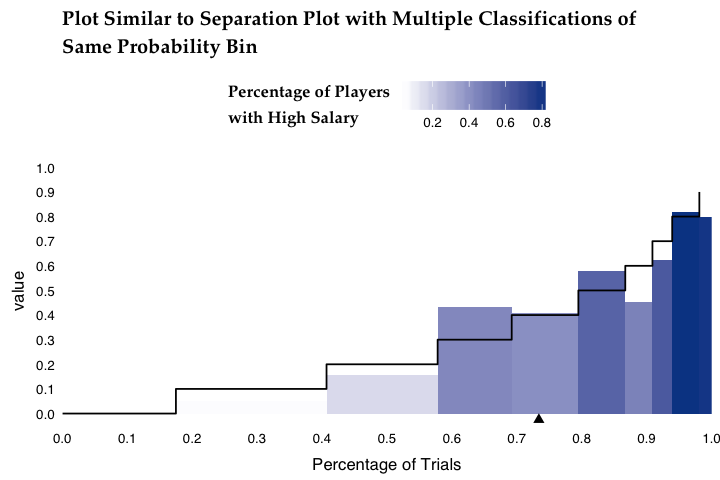

In [74]:
ggplot(data=hitters_plot_frame) + 
  geom_rect(aes(xmin=x_min_perc,xmax=x_max_perc,ymin=0,ymax=perc_high,fill=perc_high)) + 
  scale_fill_gradient(low=rgb(255,255,255,max=255),high=brewer.pal(8,"Blues")[8], name="Percentage of Players \nwith High Salary") +
  # If one wishes to plot the points of the percentage high, one can
  # geom_point(aes(x=x_max_perc,y=perc_high),shape=22,color=rgb(0,0,0,max=255),size=2,fill = rgb(255,255,255,max=255)) + geom_step(aes(x=x_max_perc,y=perc_high),lty=2) +
  # probability threshold line
  geom_step(aes(x = x_min_perc,y=year_lr_bin)) +
  # expected number of events
  geom_point(data=expected_events_df_p,aes(x=X,y=Y),shape=17,size=2) +
  scale_x_continuous(breaks=seq(0,1,by=0.1),expand=c(0,0)) + scale_y_continuous(breaks=seq(0,1,by=0.1)) +
  coord_cartesian(ylim=c(0,1)) +
  theme(legend.position="top") + xlab("Percentage of Trials") + ylab("value") + ggtitle("Plot Similar to Separation Plot with Multiple Classifications of \nSame Probability Bin")

## Plotting the Model in the Data Space

The second research concept we cover in this presentation is the concept of **ploting the model in the data space**. This is from the research paper:

Wickham, H., Cook, D. and Hofmann, H. (2015), Visualizing statistical models: Removing the blindfold. Statistical Analysis and Data Mining: The ASA Data Science Journal, 8: 203–225. doi:10.1002/sam.11271

We illustrate this with a plot of a decision tree on two variables.  With the hitters set, a classification tree (that outputs classes, not probabilities) was run on the features `Years` and `Average`.

One could diagram the tree such as below, but this is plotting the data in the model space, which is not as good. (This is not just because we did not take the time to pretty up this plot, which can be done.)

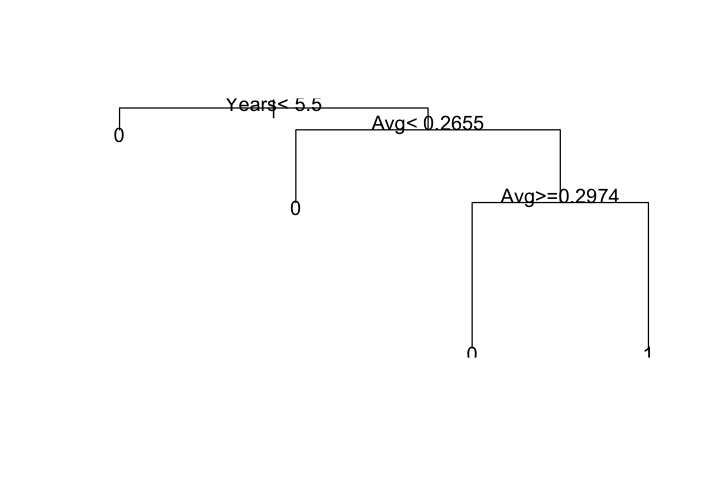

In [76]:
plot(high_sal_tree)
text(high_sal_tree)

However, we will plot this in the data space, with all of the data points. To do so, we will color and shape each point by its correct class and will then shade the area by the color of the class predicted by the decision tree. This is plotting the model in the data space.

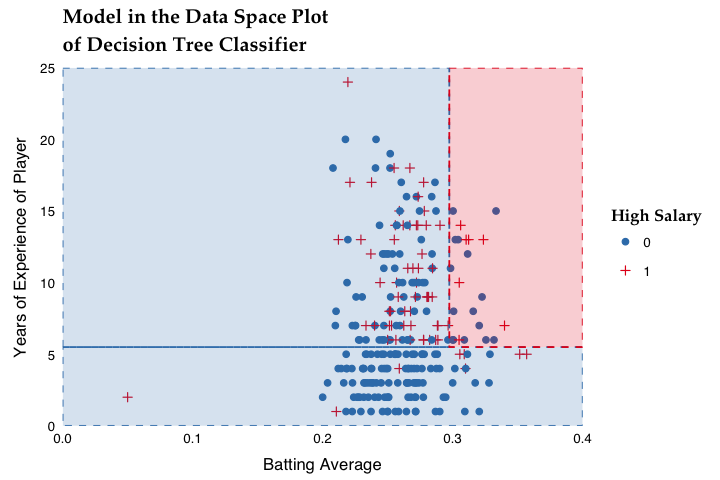

In [77]:
class_cols <- brewer.pal(4,"Set1")
class_shapes <- c(19,3)

# These are set to be purposefully larger than the largest values to show some space in the plot
max_x <- 0.4
max_y <- 25

ggplot() + geom_point(data=hitters_class_frame, aes(x=Avg, y=Years, color=high_salary,shape=high_salary))  + scale_color_manual(values=class_cols[c(2,1)],name="High Salary")+ scale_shape_manual(values=class_shapes,name="High Salary") +
# rectangle 1
  geom_rect(aes(xmin=0, xmax=max_x, ymin=0,ymax=5.5), alpha=0.2,fill=class_cols[2], color=class_cols[2], lty=2) +
# rectangle 2
  geom_rect(aes(xmin=0,xmax=0.2974, ymin=5.5,ymax = max_y), alpha=0.2, fill=class_cols[2], color=class_cols[2],lty=2) +
# rectangle 3
  geom_rect(aes(xmin=0.2974, xmax=max_x,ymin=5.5, ymax=max_y), alpha=0.2, fill=class_cols[1], color=class_cols[1],lty=2) +
  scale_x_continuous(expand= c(0,0)) + scale_y_continuous(expand=c(0,0)) +
  coord_cartesian(xlim=c(0,max_x),ylim=c(0,max_y)) +
  xlab("Batting Average") + ylab("Years of Experience of Player") + ggtitle("Model in the Data Space Plot \nof Decision Tree Classifier")

Notice that ggplot automatically combines the legends because they have the same name. If we want different ones, we can just give them a different name.

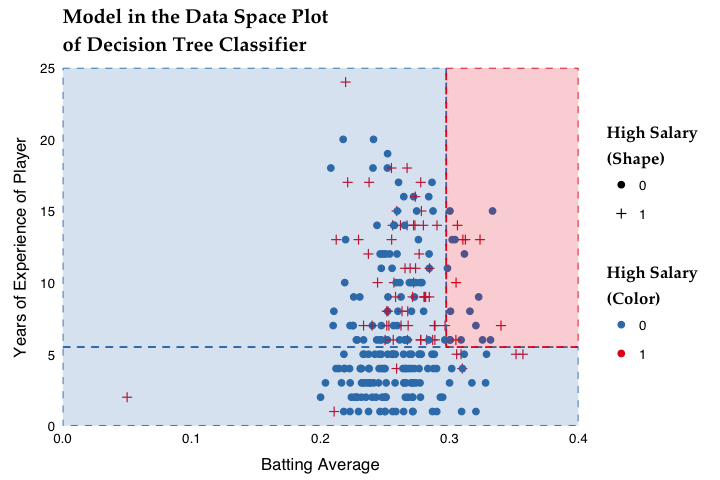

In [83]:
ggplot() + geom_point(data=hitters_class_frame, aes(x=Avg, y=Years, color=high_salary,shape=high_salary))  + scale_color_manual(values=class_cols[c(2,1)],name="High Salary \n(Color)")+ scale_shape_manual(values=class_shapes,name="High Salary \n(Shape)") +
# rectangle 1
  geom_rect(aes(xmin=0, xmax=max_x, ymin=0,ymax=5.5), alpha=0.2,fill=class_cols[2], color=class_cols[2], lty=2) +
# rectangle 2
  geom_rect(aes(xmin=0,xmax=0.2974, ymin=5.5,ymax = max_y), alpha=0.2, fill=class_cols[2], color=class_cols[2],lty=2) +
# rectangle 3
  geom_rect(aes(xmin=0.2974, xmax=max_x,ymin=5.5, ymax=max_y), alpha=0.2, fill=class_cols[1], color=class_cols[1],lty=2) +
  scale_x_continuous(expand= c(0,0)) + scale_y_continuous(expand=c(0,0)) +
  coord_cartesian(xlim=c(0,max_x),ylim=c(0,max_y)) +
  xlab("Batting Average") + ylab("Years of Experience of Player") + ggtitle("Model in the Data Space Plot \nof Decision Tree Classifier") 

# Disclaimer

The claims and opinions expressed in these slides are my personal opinions, and shall not be misinterpreted or construed to be the opinions of my employer or the U.S. Government.

# Contact

For questions, comments, or feedback, contact:

Peter Fontana

peter.c.fontana@gmail.com

https://www.linkedin.com/in/petercfontana